In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
from datetime import datetime
import pandas as pd
from typing import Optional, List
import copy

from datetime import datetime, timedelta

from wellplan.core import TeamPool
from wellplan.core.plan import WellPlanContext
from wellplan.services import (
    TeamManager,
    FileProductionProfile,
    ArpsDeclineProductionProfile,
    NPV,
    BaseCapex,
    BaseOpex,
    ClusterRandomRiskStrategy,
    DistanceTeamMovement,
    OilConstraint,
    CapexConstraint
)


from wellplan.services.visualization import GraphVisualizer, GantVisualizer
from wellplan.services.infrastructure import SimpleInfrastructure, Infrastructure
from wellplan.services.cost import CostFunction
from wellplan.core.plan import Constraint, Plan
from wellplan.core.well import Well  
from wellplan.services.team_manager import BaseTeamManager
from wellplan.services.risk_strategy import RiskStrategy    
from wellplan.services.production import ProductionProfile
from wellplan.data.file.loader import ExcelWellLoader
from wellplan.data.file.saver import ExcelPlanSaver
from wellplan.builder import PlanBuilder


import torch.nn.init as init
import math
import matplotlib.pyplot as plt

data_path = r"D:\working_profile\projects\well-plan-optimization\notebooks\dump\external"


loader = ExcelWellLoader(file_path=fr"{data_path}\Ввод ЭБ 1+11 Обезлич_v3.xlsx",)
wells = loader.load()[:8] # Ограничиваем количество скважин 8 в рамках эксперемента
production_profile = FileProductionProfile(folder_path='external\profiles')

coordinates = pd.read_excel(
    fr"{data_path}\База перспективного ПФ (30.01.2025) (2).xlsm",
    header=0,
    names=["cluster", "x", "y", "z"],
)
movement = DistanceTeamMovement.from_dicts(coordinates.to_dict(orient="records"))

In [2]:
# TODO: попробовать feature engeneering
# wells - поссмотреь почему пустой

In [3]:
# Улучшение 1: Инициализация весов
def init_weights(m, method="xavier"):
    if isinstance(m, nn.Linear):
        if method == "xavier":
            init.xavier_uniform_(m.weight)
        elif method == "kaiming":
            init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


In [4]:
# Нейронка, используемая как Q-функция, костфункция для оценивания действия (кандидата-скважины)
class QNetwork(nn.Module, CostFunction):
    def __init__(self, 
        config,
        input_size = 5, 
        # tau = 0.99,  # как много задела делаем на след шаг (одношаговый подход)
    ):
        super(QNetwork, self).__init__()
        """Архитектура Q-сетки"""
        self.config = config
        self.input_size = input_size
        self.NPV = config["NPV"]

        layers = []
        input_size += self.config["water_cut"] + self.config["interaction_rate_length"]\
            + self.config["start_day"] + self.config["profit_per_well"] + self.config["log_profit"]\
            + self.config.get("use_time_features", False) * 2 + self.config["use_purpose"]
        in_dim = input_size
        activation_fn =  self.config["activation_fn"]

        for hidden_dim in self.config["hidden_layers"]:
            layers.append(nn.Linear(in_dim, hidden_dim))
            # if self.config.use_batchnorm:
                # layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(activation_fn())
            if self.config["dropout_rate"] > 0.0:
                layers.append(nn.Dropout(self.config["dropout_rate"]))
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, 1))
        self.model = nn.Sequential(*layers)

        # Разделение state и action encoderов
        # if self.config.get("use_separate_encoders", False):  # Улучшение 2
        #     self.state_encoder = nn.Sequential(
        #         nn.Linear(self.config["state_dim"], 64),
        #         activation_fn(),
        #     )
        #     self.action_encoder = nn.Sequential(
        #         nn.Linear(self.config["action_dim"], 64),
        #         activation_fn(),
        #     )
        #     self.merged = nn.Sequential(
        #         nn.Linear(128, 64),
        #         activation_fn(),
        #         nn.Linear(64, 1),
        #     )

        # Инициализация весов
        if self.config.get("weight_init_method", False):  # Улучшение 1
            self.model.apply(lambda m: init_weights(m, method=self.config["weight_init_method"]))


        # self.tau = tau
        
        loss_fn =  self.config["loss_fn"]
        if self.config["optimizer"]:
            self.optimizer = self.config["optimizer"](self.parameters(), lr=self.config["learning_rate"]) 
        else:
            self.optimizer = optim.AdamW(self.parameters(), lr=self.config["learning_rate"], weight_decay = self.config.get("weight_decay"))
        self.criterion = loss_fn()
        # self.gamma = gamma  # Коэффициент дисконтирования  # не реализовано

    def forward(self, x):
        x = self.model(x)
        return x

    def compute(self, state: Plan, action: WellPlanContext) -> WellPlanContext:
        """Оценка стоимости действия (контекста) при текущем состоянии state"""
        x = self._state_and_action_to_tensor(state = state, action = action)
        x = x.unsqueeze(0)
        
        print(f"before forward {action.cost}")
        with torch.no_grad():          
            cost = self.forward(x)
        action.cost = cost.item()  # обновление коста - перезатирка
        print(f"after forward {action.cost}")
        return action

    def _state_and_action_to_tensor(self, state: Plan, action: WellPlanContext) -> torch.Tensor:
        """Векторизация фичей для агента, для оценки действия action, при текущем состоянии state"""
        
        features = [
            action.well.oil_rate,
            action.well.liq_rate,
            action.well.length,
            # len(action.entries),
            # action.start.timestamp() / 86400,
            # state
        ]

        # Engineered features
        if self.config["water_cut"]:
            water_cut = action.well.oil_rate / (action.well.liq_rate + 1e-8)
            features.append(water_cut)

        if self.config["interaction_rate_length"]:
            features.append(action.well.oil_rate * action.well.length)

        if self.config["start_day"]:
            features.append(action.start.timestamp() / 86400)

        # State-based features
        features += [len(state.well_plans), state.total_npv(self.NPV)]
        if self.config["profit_per_well"]:
            features.append(state.total_npv(self.NPV) / (len(state.well_plans) + 1e-6))

        if self.config["log_profit"]:
            features.append(np.log1p(state.total_npv(self.NPV)))

        if self.config.get("use_time_features", False):
            day = action.start.timetuple().tm_yday
            features += [
                math.sin(2 * math.pi * day / 365),
                math.cos(2 * math.pi * day / 365),
            ]

        if self.config["use_purpose"]:
            purpose = action.well.purpose
            feature = 1 if purpose == "Добывающая" else 0
            features.append(feature)
        return torch.FloatTensor(features)

    def update(self, state: Plan, action: WellPlanContext) -> None:
        """Действие, Обучение Q-сети, настройка весов на награде за этой действие"""
        # 1. Преобразуем входные данные в тензоры
        # print(f"update: {state=}")
        state_tensor = self._state_and_action_to_tensor(state=state, action=action).unsqueeze(0)
        
        # 2. Вычисляем награду (убедитесь, что total_npv() возвращает float)
        prev_npv = state.total_npv(self.NPV)
        new_state = copy.deepcopy(state)
        # print(f"update: {new_state=}")
        new_state.add_context(action)
        # print(f"{new_state.total_npv(self.NPV)=}")
        reward = new_state.total_npv(self.NPV) - prev_npv
        
        # 3. Преобразуем reward в тензор с правильной размерностью
        # if self.config["reward_smoothing_alpha"]:
        #     # 2 
        #     alpha = self.config["reward_smoothing_alpha"]
        #     if not hasattr(self, "_smoothed_reward"):
        #         self._smoothed_reward = reward
        #     reward = (1 - alpha) * self._smoothed_reward + alpha * reward
        # if self.config["reward_tahn_norm"]:
        #     reward = np.tanh(reward / self.config["reward_tahn_norm"])
        reward_tensor = torch.tensor([[reward]], dtype=torch.float32)
        
        # 4. Получаем Q-значение для текущего состояния и действия
        q_value = self.forward(state_tensor)  # Размерность: [1, 1]
        
        # 5. Вычисляем loss (теперь оба параметра - тензоры)
        loss = self.criterion(q_value, reward_tensor)  # Добавляем размерность
        
        # 6. Оптимизация
        self.optimizer.zero_grad()
        loss.backward()
        if self.config["gradient_clipping"]:
            torch.nn.utils.clip_grad_norm_(self.parameters(), self.config["gradient_clipping"])
        self.optimizer.step()

DQN = QNetwork()

team_pool = TeamPool()
team_pool.add_teams(['ГС'], num_teams=2)
team_pool.add_teams(['грп'], num_teams=2)
manager = TeamManager(team_pool=team_pool)

state = Plan()
next_state = Plan()
action = WellPlanContext(well = wells[0], 
                                                start=datetime.now(),
                                                end=datetime.now() + timedelta(days=1))
next_state.add_context(action)
DQN.update(state = state, 
           action = action)

In [5]:
class DQNAgent(PlanBuilder):
    def __init__(
        self,
        start: datetime,
        end: datetime,
        input_size: int,
        qnetwork_cfg: dict,
        learning_rate: float = 0.001,
        epsilon: float = 0.2,
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.05,
        weight_decay: float = None,
        **kwargs
    ):
        # Создаем QNetwork как cost_function
        self.q_network = QNetwork(config=qnetwork_cfg)
        self.npv=qnetwork_cfg["NPV"]
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=learning_rate, weight_decay = weight_decay)
        
        # Параметры для epsilon-жадной стратегии
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Инициализируем базовый класс
        super().__init__(
            start=start,
            end=end,
            cost_function=self.q_network
        )


    def _select_best_candidate(self, candidates: List[WellPlanContext], keep_order: bool = False) -> WellPlanContext:
        """
        Выбор лучшего кандидата с использованием QNetwork и epsilon-жадной стратегии
        """
        if random.random() < self.epsilon:
            return random.choice(candidates)
        
        
        # Оцениваем каждого кандидата
        best_value = float('-inf')
        best_candidate = np.random.choice(candidates)  # TODO: это исправление бага, если value.item() = Nan
        
        for candidate in candidates:
            # Преобразуем кандидата в тензор
            input_tensor = self.q_network._state_and_action_to_tensor(state=self.plan, action=candidate)
            
            # Получаем оценку от QNetwork
            with torch.no_grad():
                value = self.q_network(input_tensor)
            
            if value.item() > best_value:
                best_value = value.item()
                best_candidate = candidate
        # print("random assignment")
        # print(f"{value.item()=}; {best_candidate=}; {best_value=}")
        # print(f"N candidates: {len(candidates)}")
        # print(f"BEST: {best_candidate};")
        # print(f"WELL: {best_candidate.well=}")
        return best_candidate

    def compile(
        self,
        wells: List[Well],
        manager: BaseTeamManager,
        risk_strategy: Optional[RiskStrategy] = None,
        keep_order: bool = False,
    ) -> Plan:
        """
        Генерация плана с обучением QNetwork
        """
        self.plan = Plan()
        self.remaining_wells = wells.copy()
        current_start = self.start

        while self.remaining_wells and current_start < self.end:
            # Получаем кандидатов
            candidates = self._build_contexts(manager, current_start)  # 2050 (self.end у всех)
            # print(f"oil_prod_profiles per candidate :{[candidate.oil_prod_profile for candidate in candidates]=}")  # TODO: пустые oil_prod_profile
            # print(f".compile: {[c.end for c in candidates]}") 
            if not candidates:
                break

            # Фильтруем кандидатов и вычисляем их стоимость
            if risk_strategy:
                candidates = [risk_strategy.apply_risk(c) for c in candidates]
            
            # Вычисляем стоимость для каждого кандидата
            candidates = [self.cost_function.compute(state=self.plan, action=c) for c in candidates]  # Qnetwork
            # costs = [candidate.cost for candidate in candidates]
            # candidate.npv

            # TODO: костыль для расчёта NPV; после возвращаем 
            for candidate in candidates:
                print('------------')
                q_cost = candidate.cost
                print(f"QCOST: {q_cost}")
                self.npv.compute(candidate)
                print(f"NPV: {candidate.cost}")
                npv_value = candidate.cost
                candidate.npv_value = npv_value
                print(f"NPV: {candidate.npv_value}")
                candidate.cost = q_cost  # вернули q_cost как cost
                print(f"QCOST: {candidate.cost}")
                print(f"NPV: {candidate.npv_value}")
                print(f"candidate.cost: {candidate.cost}")
                print('------------')

            

            # Фильтруем по ограничениям
            candidates = [
                c for c in candidates if not self._constraints.is_violated(self.plan, c)
            ]
            
            if not candidates:
                current_start = self._constraints.get_period_end(current_start) or self.end
                continue

            # Выбираем лучшего кандидата
            best_candidate = self._select_best_candidate(candidates, keep_order)
            print(f"{best_candidate.cost=}")
            
            
            # После выбора действия обучаем QNetwork
            if best_candidate is None:
                print(f"{best_candidate=}; {len(candidates)=}")
            print(f"before self.q_network.update {best_candidate.cost=}")
            self.q_network.update(state=self.plan, action=best_candidate)
            print(f"after self.q_network.update {best_candidate.cost=}")
            
            # Уменьшаем epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay  
            
            # Добавляем в план
            manager.assign(best_candidate)
            # print(f"remaining_wells ДО УДАЛЕНИНИЯ ({len(self.remaining_wells)})")
            self.remaining_wells.remove(best_candidate.well)
            # print(f"ДО add_context: {len(self.plan.well_plans)}; {self.plan.id}")
            self.plan.add_context(best_candidate)
            print(f"{best_candidate.cost=}")
            # print(f"ПОСЛЕ add_context: {len(self.plan.well_plans)}; {self.plan.id}")
            # print(f"remaining_wells ({len(self.remaining_wells)}): {self.remaining_wells}")
            

            # Обновляем время
            # current_start = best_candidate.end
            # print(f"clause 1: {self.remaining_wells}")
            # print(f"clause 2: {current_start < self.end} ({current_start=}); ({self.end=})")
            # print(f"compile: {self.remaining_wells=}") 
            # print(f"compile: {current_start < self.end=};\n({current_start=}; {self.end=})")

        return self.plan


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.should_stop = False

    def step(self, current_score):
        if self.best_score is None or current_score > self.best_score + self.min_delta:
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True



# Запуск обучения
TODO: 
* функция получения состояния
* реализация базового фонда в plan
* ? наследование плана

In [6]:

class HuberLoss(nn.Module):
    def __init__(self, weight=0.75, delta=2.0):
        super().__init__()
        self.weight = weight
        self.delta = delta

    def forward(self, input, target):
        error = target - input
        abs_error = torch.abs(error)
        huber = torch.where(
            abs_error < self.delta,
            0.5 * error ** 2,
            self.delta * (abs_error - 0.5 * self.delta)
        )
        loss = torch.where(error >= 0, self.weight * huber, (1 - self.weight) * huber)
        return loss.mean()

before forward None
after forward 5.6435370445251465
before forward None
after forward 38.37831497192383
before forward None
after forward 5.648679256439209
before forward None
after forward 20.11111831665039
before forward None
after forward -3.6662917137145996
before forward None
after forward 22.364381790161133
before forward None
after forward 19.337732315063477
before forward None
after forward 4.967545986175537
------------
QCOST: 5.6435370445251465
NPV: 1267975782.6382759
NPV: 1267975782.6382759
QCOST: 5.6435370445251465
NPV: 1267975782.6382759
candidate.cost: 5.6435370445251465
------------
------------
QCOST: 38.37831497192383
NPV: 1269451351.126854
NPV: 1269451351.126854
QCOST: 38.37831497192383
NPV: 1269451351.126854
candidate.cost: 38.37831497192383
------------
------------
QCOST: 5.648679256439209
NPV: 1457057730.447075
NPV: 1457057730.447075
QCOST: 5.648679256439209
NPV: 1457057730.447075
candidate.cost: 5.648679256439209
------------
------------
QCOST: 20.1111183166503

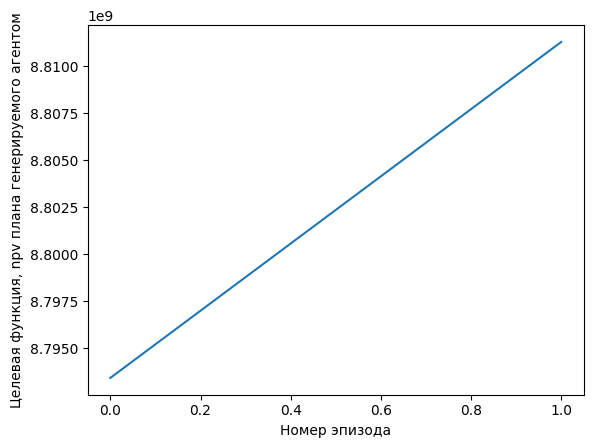

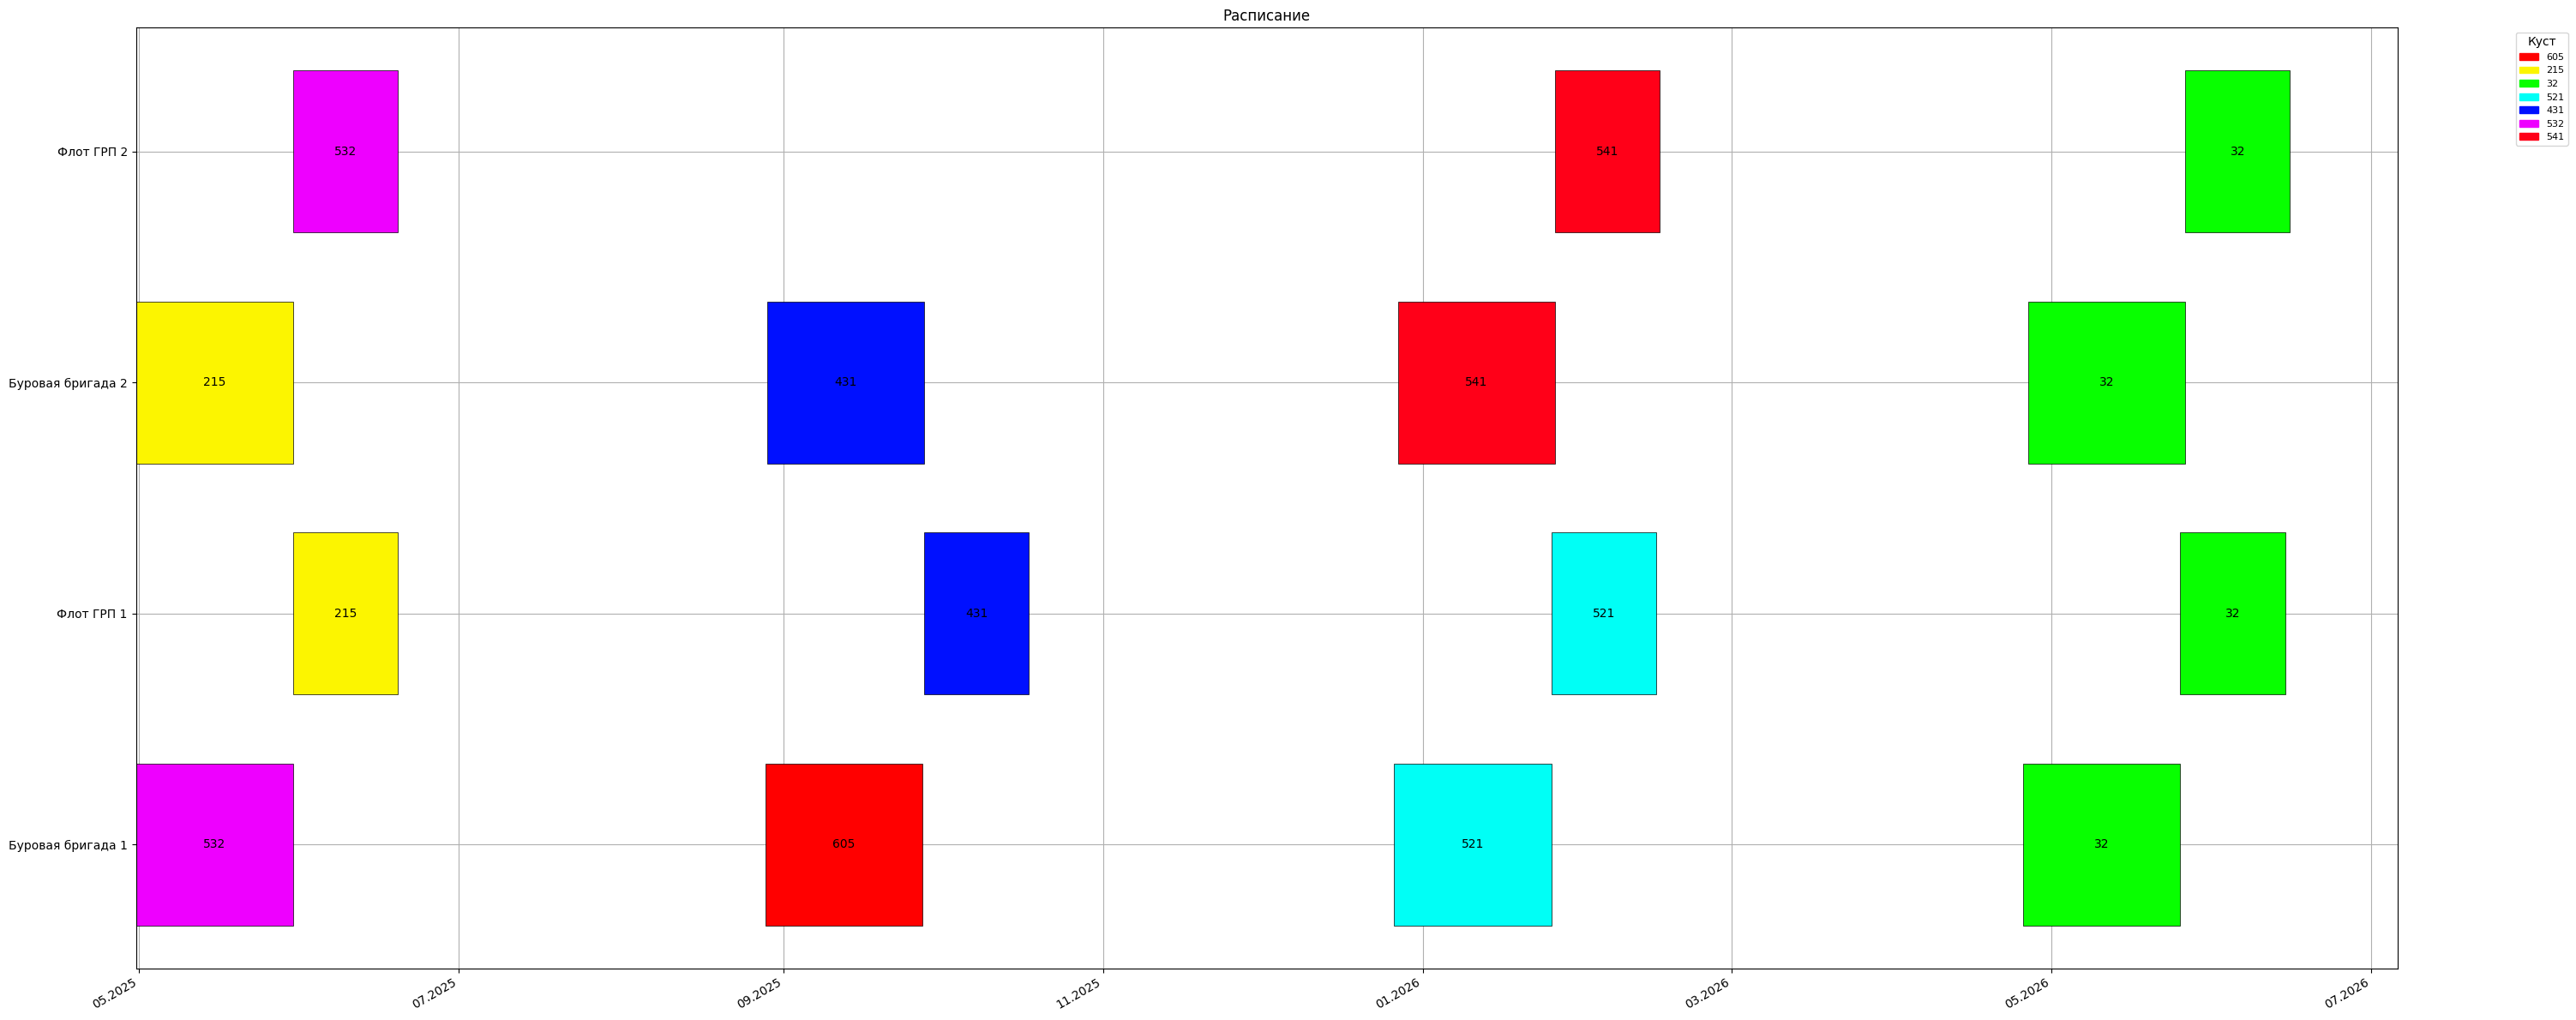

In [7]:
# TODO: WELLPLan из одного контекста
# TODO: проверить avialable brigadue

n_episodes = 2

# qnetwork_cfg = {
#     # "tau": 0.1
#     "water_cut": 0, #
#     "interaction_rate_length": 0, #
#     "start_day": 0, #
#     "profit_per_well": 0, #
#     "log_profit": 0, #
#     "hidden_layers": [64, 32], #
#     "activation_fn": torch.nn.ReLU,
#     "dropout_rate": 0.1, #
#     "optimizer": None,
#     "loss_fn": HuberLoss, #nn.MSELoss,
#     "learning_rate": 1e-4, # 1e-3
#     "use_purpose": 0,#
#     "reward_smoothing_alpha": 0,
#     "gradient_clipping": 0,
#     "weight_decay": 1e-5,
#     "reward_tahn_norm": 0
# }
### NPV
capex = BaseCapex(
    build_cost_per_metr={
        "ГС+ГРП": 25300,
        "ННС+ГРП": 12900,
        "МЗС": 27300,
        "МЗС+ГРП": 28300,
        "ГС": 23300,
    },
    equipment_cost=2500000,
)
opex = BaseOpex(
    oil_cost_per_tone=109.9,
    water_cost_per_tone=48.6,
    repair_per_year=3093900,
    maintain_per_year=2336200,
)

npv = NPV(
    oil_price_per_tone=13896,
    project_start_date=datetime.now(),
    capex_cost=capex,
    opex_cost=opex,
    discount_rate=0.125,
)

qnetwork_cfg = {
    # "tau": 0.1
    "water_cut": 0, #
    "interaction_rate_length": 0, #
    "start_day": 0, #
    "profit_per_well": 0, #
    "log_profit": 0, #
    "hidden_layers": [32, 16], #
    "activation_fn": torch.nn.ReLU,
    "dropout_rate": 0.1, #
    "optimizer": None,
    "loss_fn": nn.MSELoss, # HuberLoss, #nn.MSELoss,
    "learning_rate": 1e-4, # 1e-3
    "use_purpose": 0,#
    "weight_decay": 1e-5,
    
    "reward_smoothing_alpha": 0,
    "gradient_clipping": 0,
    "reward_tahn_norm": 0,
    "NPV": npv
}




# Создаем экземпляр агента
agent = DQNAgent(
    qnetwork_cfg = qnetwork_cfg,
    start=datetime.now(),
    end=datetime.now() + timedelta(days=365 * 25),
    input_size=5,  # размерность входа QNetwork, количество фичей
    learning_rate=1e-4,
    epsilon=0.2,
    infrastructure=SimpleInfrastructure(),
    production_profile=production_profile,
    weight_decay=qnetwork_cfg["weight_decay"]
)
plans = [] # Собираем генерируемые агентом сценарии в массив для отслеживания динамики



# Параметры
  # Количество эпизодов обучения
# Обучение на нескольких эпизодах
for episode in range(n_episodes):

    # Создаем пул команд, что бы каждый эпизод исходные условия были одинаковые
    team_pool = TeamPool()
    team_pool.add_teams(['ГС'], num_teams=2)
    team_pool.add_teams(['грп'], num_teams=2)


    manager = TeamManager(team_pool=team_pool, movement=movement) # 
    
    plan = agent.compile(wells=wells.copy(), manager=manager)

    plans.append(plan)

metric = sum([wp.npv_value for wp in plans[-1].well_plans])


plt.plot(list(range(len(plans))), [sum([wp.npv_value for wp in plan.well_plans]) for plan in plans])
plt.ylabel('Целевая функция, npv плана генерируемого агентом')
plt.xlabel('Номер эпизода')
plt.show()

viz = GantVisualizer(figsize=(30, 12))
viz.render_by_teams(plans[-1])

In [8]:
len(plans[-1].well_plans)

plans[-1].total_profit() == sum([wp.npv_value for wp in plans[-1].well_plans])  # total_profit = npv_value
sum([wp.npv_value for wp in plans[-1].well_plans]) == sum([wp.cost for wp in plans[-1].well_plans]) # npv_value = costs

True

In [8]:
[wp.npv_value for wp in plans[-1].well_plans]

[1257276506.5936372,
 1268423459.1523428,
 1266203281.7867436,
 1085976398.3426628,
 1206326766.0339718,
 1073595498.3852928,
 877441879.8418944,
 983358042.2532282]

In [9]:
[print(wp.cost) for wp in plans[-1].well_plans]

1257276506.5936372
1268423459.1523428
1266203281.7867436
1085976398.3426628
1206326766.0339718
1073595498.3852928
877441879.8418944
983358042.2532282


[None, None, None, None, None, None, None, None]

In [12]:
# plans[-1].well_plans[0].oil_prod_profile

In [13]:
8958875400.681797//1e9

8.0

In [26]:
sum([wp.npv_value for wp in plans[-1].well_plans])

8814294140.980843

In [28]:
sum([wp.cost for wp in plans[-1].well_plans])

8814294140.980843

In [15]:
[well.well.name for well in plans[-1].well_plans]

['657', '6743', '6912', '6464', '5611', '658', '1705', '4528']

In [17]:
plans[-1].well_plans[0].cost/1e9

1.269897122967105

In [18]:
# agent.q_network.NPV.compute

In [19]:
# npv.compute(context=wells[0])
# wells[0].npv(npv)

# TODO:

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[10], line 75
     70     team_pool.add_teams(['грп'], num_teams=2)
     73     manager = TeamManager(team_pool=team_pool, movement=movement) # 
---> 75     plan = agent.compile(wells=wells.copy(), manager=manager)
     77     plans.append(plan)
     79 metric = plans[-1].total_profit()

Cell In[5], line 102
     98 best_candidate = self._select_best_candidate(candidates, keep_order)
    101 # После выбора действия обучаем QNetwork
--> 102 self.q_network.update(state=self.plan, action=best_candidate)
    104 # Уменьшаем epsilon
    105 if self.epsilon > self.epsilon_min:

Cell In[4], line 130
    128 """Действие, Обучение Q-сети, настройка весов на награде за этой действие"""
    129 # 1. Преобразуем входные данные в тензоры
--> 130 state_tensor = self._state_and_action_to_tensor(state=state, action=action).unsqueeze(0)
    132 # 2. Вычисляем награду (убедитесь, что total_profit() возвращает float)
    133 prev_npv = state.total_profit()

Cell In[4], line 87
     83 def _state_and_action_to_tensor(self, state: Plan, action: WellPlanContext) -> torch.Tensor:
     84     """Векторизация фичей для агента, для оценки действия action, при текущем состоянии state"""
     86     features = [
---> 87         action.well.oil_rate,
     88         action.well.liq_rate,
     89         action.well.length,
     90         # len(action.entries),
     91         # action.start.timestamp() / 86400,
     92         # state
     93     ]
     95     # Engineered features
     96     if self.config["water_cut"]:

AttributeError: 'NoneType' object has no attribute 'well'

# Optuna

In [20]:
import optuna

input_size = 5
n_episodes = 10000
patience = 500


def train(agent, n_episodes, patience=None, plans = None):
    plans = [] if not plans else plans
    if patience:
        early_stopper = EarlyStopping(patience=patience)
    for episode in range(n_episodes):
        team_pool = TeamPool()
        team_pool.add_teams(['ГС'], num_teams=2)
        team_pool.add_teams(['грп'], num_teams=2)
        manager = TeamManager(team_pool=team_pool) 
        plan = agent.compile(wells=wells.copy(), manager=manager)
        plans.append(plan)
        if patience:
            metric = plan.total_npv(agent.q_network.NPV)
            early_stopper.step(metric)
            if early_stopper.should_stop:
                break
    return plans

def objective(trial: optuna.Trial):
    # try:
        # Подбираемые параметры
    hidden_layers = [
        trial.suggest_categorical("layer_1", [64, 128, 256, 512, 1024]),
        trial.suggest_categorical("layer_2", [16, 32, 64, 128])
    ]
    layer3 = trial.suggest_categorical("layer_3", [None, 16, 32, 64, 128])
    hidden_layers.append(layer3) if layer3 else None  # третий слой?

    # use_batchnorm = False # trial.suggest_categorical("batchnorm", [False, True])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.15, step=0.05)
    # tau = trial.suggest_float("tau", 0.5, 1.0, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-7, 1e-3, log=True)
    learning_rate_agent = trial.suggest_float("learning_rate_agent", 1e-7, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-3, log=True)
    gradient_clipping = 0 # trial.suggest_float("gradient_clipping", 0.1, 100.0, log=True)
    weight_init_method = trial.suggest_categorical("weight_init_method", [None, "kaiming", "xavier"])
    reward_tahn_norm = 0 # trial.suggest_float("reward_tahn_norm", 0.0, 1e6)
    reward_smoothing_alpha = 0 #trial.suggest_float("reward_smoothing_alpha", 0.0, 1.0)

    # Активация, оптимайзер и функция потерь
    activation_fn = trial.suggest_categorical("activation_fn", [nn.ReLU, nn.LeakyReLU])
    # optimizer = trial.suggest_categorical("optimizer", [optim.Adam, optim.SGD])
    loss_fn = trial.suggest_categorical("loss_fn", [nn.MSELoss, nn.SmoothL1Loss,  HuberLoss])
    epsilon = trial.suggest_float("epsilon", 0.01, 0.8, log=True)

    # feature engeneering
    water_cut = trial.suggest_categorical("water_cut", [0, 1])
    interaction_rate_length = trial.suggest_categorical("interaction_rate_length", [0, 1])
    start_day = trial.suggest_categorical("start_day", [0, 1])
    profit_per_well = trial.suggest_categorical("profit_per_well", [0, 1])
    log_profit = trial.suggest_categorical("log_profit", [0, 1])
    use_time_features = trial.suggest_categorical("use_time_features", [0, 1])
    use_purpose = trial.suggest_categorical("use_purpose", [0, 1])

    # Создание модели
    qnetwork_cfg_optuna = {
        "input_size": input_size,
        "hidden_layers": hidden_layers,
        # "use_batchnorm": use_batchnorm,
        "dropout_rate": dropout_rate,
        "weight_init_method": weight_init_method,
        # "tau": tau,
        "learning_rate": learning_rate,
        "activation_fn": activation_fn,
        "loss_fn": loss_fn,
        "optimizer": None, #optim.Adam, #optimizer - вызывает ошибки

        "water_cut": water_cut,
        "interaction_rate_length": interaction_rate_length,
        "start_day": start_day,
        "profit_per_well": profit_per_well,
        "log_profit": log_profit,
        "use_time_features": use_time_features,
        "use_purpose": use_purpose,
        "reward_smoothing_alpha":reward_smoothing_alpha,
        "reward_tahn_norm": reward_tahn_norm,
        "gradient_clipping":gradient_clipping,
        "weight_decay": weight_decay,
        "NPV": npv
    }


    agent = DQNAgent(
        qnetwork_cfg = qnetwork_cfg_optuna,
        start=datetime.now(),
        end=datetime.now() + timedelta(days=365 * 25),
        input_size=input_size,  # размерность входа QNetwork, количество фичей
        learning_rate=learning_rate_agent,
        epsilon=epsilon,
        infrastructure=SimpleInfrastructure(),
        production_profile=production_profile,
        weight_decay = weight_decay
    )



    global best_optuna_model, best_metric, best_plans
    plans = train(agent, n_episodes, patience=patience)
    metric = plans[-1].total_npv(agent.q_network.NPV)
    if 'best_metric' not in globals() or metric > best_metric:
        best_metric = metric
        best_optuna_model = agent
        best_plans = plans
    del agent
    return metric

    # except:
    #     return None

# Запуск
sampler = optuna.samplers.TPESampler(seed=0)
study = optuna.create_study(direction="maximize", sampler=sampler)

d:\working_profile\conda_envs_pkgs\envs\rl_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-28 18:19:39,245] A new study created in memory with name: no-name-2eaf2208-dccc-4126-970f-2c221e3bf5aa


In [ ]:
[well.well.name for well in plans[-1].well_plans]

In [ ]:
study.optimize(objective, n_trials=200)

In [ ]:
print("Лучший Profit:")
print(f"{study.best_value:.1f}")

print("\nЛучший запуск:")
plt.plot(list(range(len(best_plans))), [plan.total_npv(npv) for plan in best_plans])
plt.ylabel('Целевая функция, npv плана генерируемого агентом')
plt.xlabel('Номер эпизода')
plt.show()

print("Лучшие параметры:")
display(pd.DataFrame([study.best_params]))

print("\nВсе запуски:")
display(study.trials_dataframe().sort_values('value', ascending = False).drop(['number', 'datetime_start', 'datetime_complete'], axis = 1)[:10])

In [ ]:
viz = GantVisualizer(figsize=(30, 12))
viz.render_by_teams(best_plans[-1])

In [ ]:
# Создаем экземпляр агента
# Параметры
n_episodes = 5000  # Количество эпизодов обучения

cfg = study.best_params.copy()

hidden_layers = [
    cfg["layer_1"],
    cfg["layer_2"]
]
layer3 = cfg.get("layer_3")
hidden_layers.append(layer3) if layer3 else None  # третий слой?

cfg.update({'hidden_layers': hidden_layers, "input_size": input_size, "optimizer": cfg.get("optimizer", None)})
cfg.update({"reward_smoothing_alpha": 0, "reward_tahn_norm": 0, "gradient_clipping": 0})
cfg.update({"NPV": npv})

agent = DQNAgent(
    qnetwork_cfg = cfg,
    start=datetime.now(),
    end=datetime.now() + timedelta(days=365 * 25),
    input_size=5,  # размерность входа QNetwork, количество фичей
    learning_rate=cfg["learning_rate_agent"],
    epsilon=cfg["epsilon"],
    infrastructure=SimpleInfrastructure(),
    production_profile=production_profile,
    weight_decay = cfg['weight_decay']
)
plans = train(agent, n_episodes, patience = patience)
metric = plans[-1].total_npv(npv)

# Обучение на нескольких эпизодах
import matplotlib.pyplot as plt
plt.plot(list(range(len(plans))), [plan.total_npv(npv) for plan in plans])
plt.ylabel('Целевая функция, npv плана генерируемого агентом')
plt.xlabel('Номер эпизода')
plt.show()
print(metric)

**Главная цель** 


* Обогнать базовый сценарий по npv (4.460349e+09)

*Задачи*

* Добиться положительной динамики в процессе обучения (нижний график целевой функции npv должен расти со временем)

* Организовать серию экспериментов по поиску гиперпараетров QNetwork (например гридсерч)

* Написать функцию оценивающую топ какое место занимает текущая политика агента (надо сравнивать с полным перебором полученным в full_search_8_wells.ipynb)